Title: 3D Visualization of TB in Chest X-ray using Deep Learning (MiDaS).

Step 1:  Install Required Tools

timm : for vision models

opencv-python :for image handling

matplotlib : for plotting

Load the MiDaS Depth Estimation Model:It is  powerful deep learning model trained to estimate 3D depth from 2D images.

In [1]:
# Install required packages
!pip install -q timm
!pip install -q opencv-python matplotlib

# Import necessary libraries
import cv2
import torch
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import timm

# Load MiDaS model (Depth Estimation)
model_type = "DPT_Large"  # it can be "DPT_Large" either "DPT_Hybrid" or "MiDaS_small"

midas = torch.hub.load("intel-isl/MiDaS", model_type)
midas.to("cuda" if torch.cuda.is_available() else "cpu").eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 49.5 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.l

Step 2: Load and Annotate the X-ray Image

Define the bounding box coordinates  around the infected area.

Draw rectangle

Add a label ("Active Tuberculosis") using OpenCV

Draw a filled rectangle behind the text and label on image.

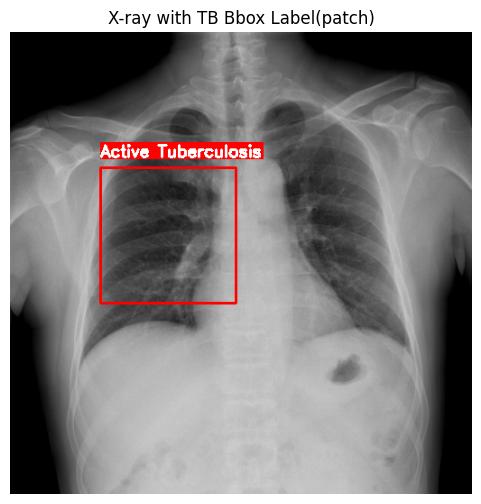

In [2]:
# Load the image
image_path = "TB_IMG.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# (x1, y1) = top-left corner, (x2, y2) = bottom-right corner
x1, y1 = 100, 150
x2, y2 = 250, 300

cv2.rectangle(image, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)

# Add label text
label = "Active Tuberculosis"
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.6
font_thick = 2

# Calculate label background size
(label_width, label_height), _ = cv2.getTextSize(label, font, font_scale, font_thick)
label_y = y1 - 10 if y1 - 10 > 10 else y1 + 20

cv2.rectangle(image, (x1, label_y - label_height - 4), (x1 + label_width, label_y), (255, 0, 0), -1)

# text label
cv2.putText(image, label, (x1, label_y - 2), font, font_scale, (255, 255, 255), font_thick)

# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')
plt.title("X-ray with TB Bbox Label(patch)")
plt.show()



Step 3: Prepare and run MiDaS for depth estimation

I send your 2D X-ray into the MiDaS model
where MiDaS returns a "depth map" — basically, which parts of the image look closer or farther.

In [3]:
input_image = transform(image).to("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    prediction = midas(input_image) #create a 3D illusion
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=image.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

depth_map = prediction.cpu().numpy()

Step 4: Visualize the depth map (pseudo-3D effect).

I use plotly to render it as a 3D surface.By using plotly users can:
1.Rotate
2.Zoom
3.Pan around the X-ray like it’s a real object.

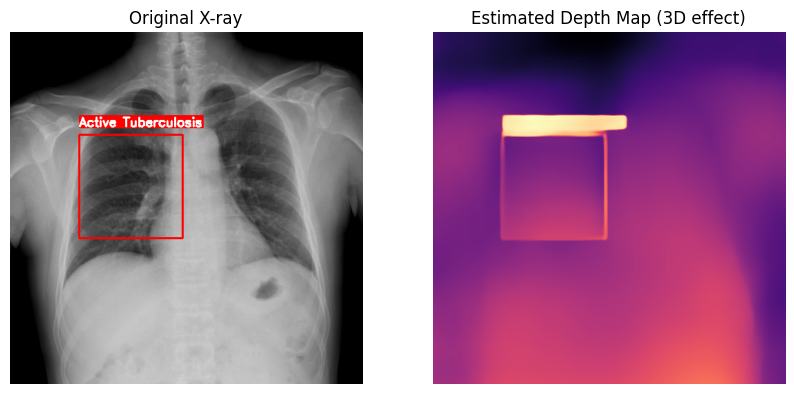

In [4]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original X-ray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(depth_map, cmap="magma")
plt.title("Estimated Depth Map (3D effect)")
plt.axis("off")
plt.show()

import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(z=depth_map, surfacecolor=cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))])
fig.update_layout(title='Interactive 3D TB X-ray', autosize=True)
fig.show()
